In [4]:
import torch

# load mnist dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# simple cnn model
from torch import nn
import torch.nn.functional as F

# optimization
from torch import optim

# training
from tqdm import tqdm

# visualization
import matplotlib.pyplot as plt

In [5]:
# load dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
trainset = datasets.MNIST('data', download=True, train=True, transform=transform)

# create dataloader
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 31575450.36it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 26687749.25it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 22287758.29it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 10117115.65it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# define model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 28x28x1 -> 14x14x32
        x = self.pool(F.relu(self.conv2(x))) # 14x14x32 -> 7x7x64
        x = x.view(-1, 64 * 7 * 7) # flatten
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# LeNet-5

# define model
class LeNet5(nn.Module):
    def __init__(self):
        super.__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5), padding=2)


        

## Saliency Map

Predicted Class: beagle


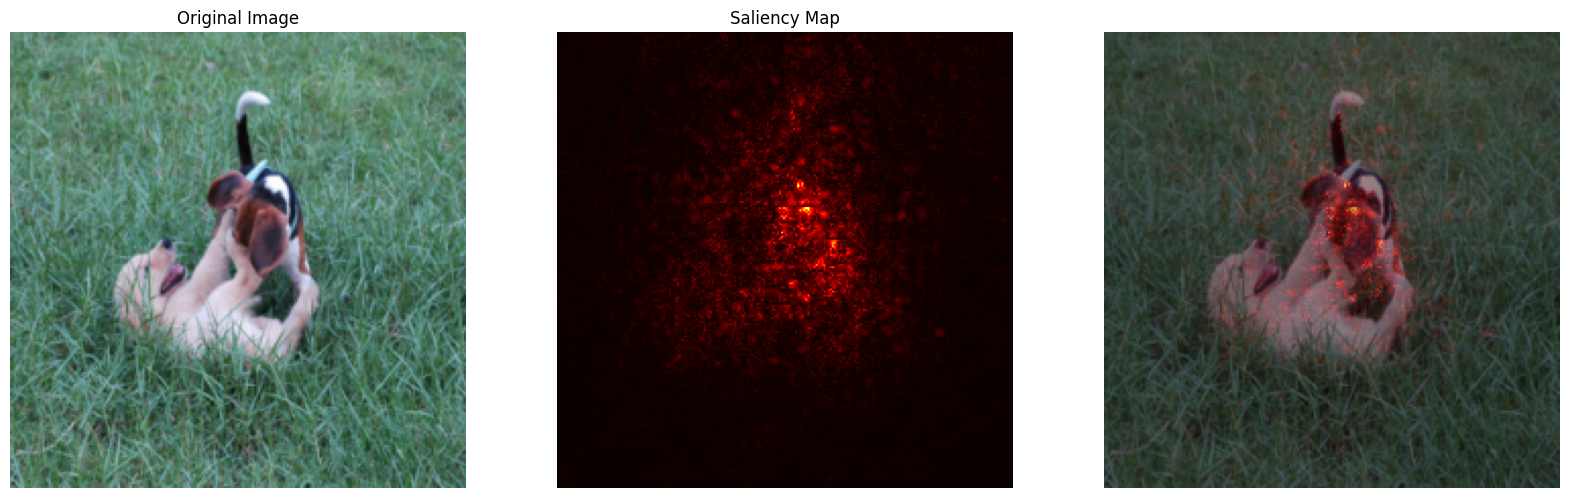

In [28]:
import torch
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image
import json
import requests

# Function to load ImageNet class index
def load_imagenet_class_index():
    url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
    response = requests.get(url)
    class_idx = json.loads(response.text)
    idx2label = {int(key): value[1] for key, value in class_idx.items()}
    return idx2label

# Load the pre-trained model
model = models.resnet152(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit the model input size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Load an image
image_path = "assets/img.jpg"  # Replace with the path to your image
image = Image.open(image_path)
image = transform(image).unsqueeze(0)  # Apply transformations and add batch dimension

# Ensure gradients are tracked for this image
image.requires_grad = True

# Forward pass to get logits
logits = model(image)

# Convert logits to probabilities
probabilities = torch.nn.functional.softmax(logits, dim=1)

# Get the top prediction
_, top_pred = probabilities.topk(1, dim=1)

# Load ImageNet class index
idx2label = load_imagenet_class_index()

# Print the predicted class
predicted_class = idx2label[top_pred.item()]
print(f"Predicted Class: {predicted_class}")


# Ensure gradients are tracked for this image
image.requires_grad = True

# Forward pass
output = model(image)
# Get the index of the max log-probability
_, index = torch.max(output, 1)

# Zero gradients
model.zero_grad()

# Backward pass
output[0, index].backward()

# Extract gradients
saliency, _ = torch.max(image.grad.data.abs(), dim=1)

# Visualize
plt.figure(figsize=(20, 10))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(transforms.ToPILImage()(image[0]))
plt.title("Original Image")
plt.axis('off')

# Saliency map
plt.subplot(1, 3, 2)
plt.imshow(saliency[0].numpy(), cmap='hot')
plt.title("Saliency Map")
plt.axis('off')

# Overlay saliency map on the original image
plt.subplot(1, 3, 3)
plt.imshow(transforms.ToPILImage()(image[0]), alpha=1)
plt.imshow(saliency[0].numpy(), cmap='hot', alpha=0.5)  # Overlay with transparency
plt.axis('off')

plt.show()